In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
from __future__ import unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

def now():
    return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

%matplotlib inline

# Introduction

The goal here is to test if there is a data leakage in the skewing of the Higgs data

## Load data

In [3]:
import os
import datawarehouse as dw

# dw.download.DATA_DIR = "/data/titanic_3/users/vestrade/datawarehouse"
# if not os.path.isdir(dw.download.DATA_DIR):
#     os.mkdir(dw.download.DATA_DIR)

from preprocessing import handle_missing_values
from preprocessing import clean_columns
# from preprocessing import log_scale

def load_Geant4_data():
    data = dw.load_higgs()  # Load the full dataset and return it as a pandas.DataFrame
    data = handle_missing_values(data)
    data = clean_columns(data)
    return data


In [5]:
data = load_Geant4_data()
data.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,1.0
1,160.937,68.768,103.235,48.146,0.00,0.000,0.000,3.473,2.078,125.157,...,1,46.226,0.725,1.158,0.000,0.00,0.000,46.226,0.681042,0.0
2,0.000,162.172,125.953,35.635,0.00,0.000,0.000,3.148,9.336,197.814,...,1,44.251,2.053,-2.028,0.000,0.00,0.000,44.251,0.715742,0.0
3,143.905,81.417,80.943,0.414,0.00,0.000,0.000,3.310,0.414,75.968,...,0,0.000,0.000,0.000,0.000,0.00,0.000,-0.000,1.660654,0.0
4,175.864,16.915,134.805,16.405,0.00,0.000,0.000,3.891,16.405,57.983,...,0,0.000,0.000,0.000,0.000,0.00,0.000,0.000,1.904263,0.0


## Skewing function

In [6]:
def skew(data, sysTauEnergyScale=1.0, missing_value=0., remove_mass_MMC=True):
    data_skewed = data.copy()
    if not "DER_mass_MMC" in data_skewed.columns:
        data_skewed["DER_mass_MMC"] =  np.zeros(data.shape[0]) # Add dummy column

    dw.higgsml.tau_energy_scale(data_skewed, sysTauEnergyScale, missing_value=missing_value)  # Modify data inplace
    data_skewed = data_skewed.drop(["ORIG_mass_MMC", "ORIG_sum_pt"], axis=1)

    if remove_mass_MMC and "DER_mass_MMC" in data_skewed.columns:
        data_skewed = data_skewed.drop( ["DER_mass_MMC"], axis=1 )
    return data_skewed

def cut(data, threshold=22.0):
    data_cut = data[data['PRI_tau_pt'] > threshold]
    return data_cut


# Visualization




In [7]:
z = 1.05

## Difference

In [8]:
diff = skew(data, sysTauEnergyScale=1.0) - skew(data, sysTauEnergyScale=z)

### Changed columns

In [ ]:
changed_cols = [c for c in diff if np.any( diff[c] != 0 )]
unchanged_cols = [c for c in diff if np.all( diff[c] == 0 )]

### Histograms

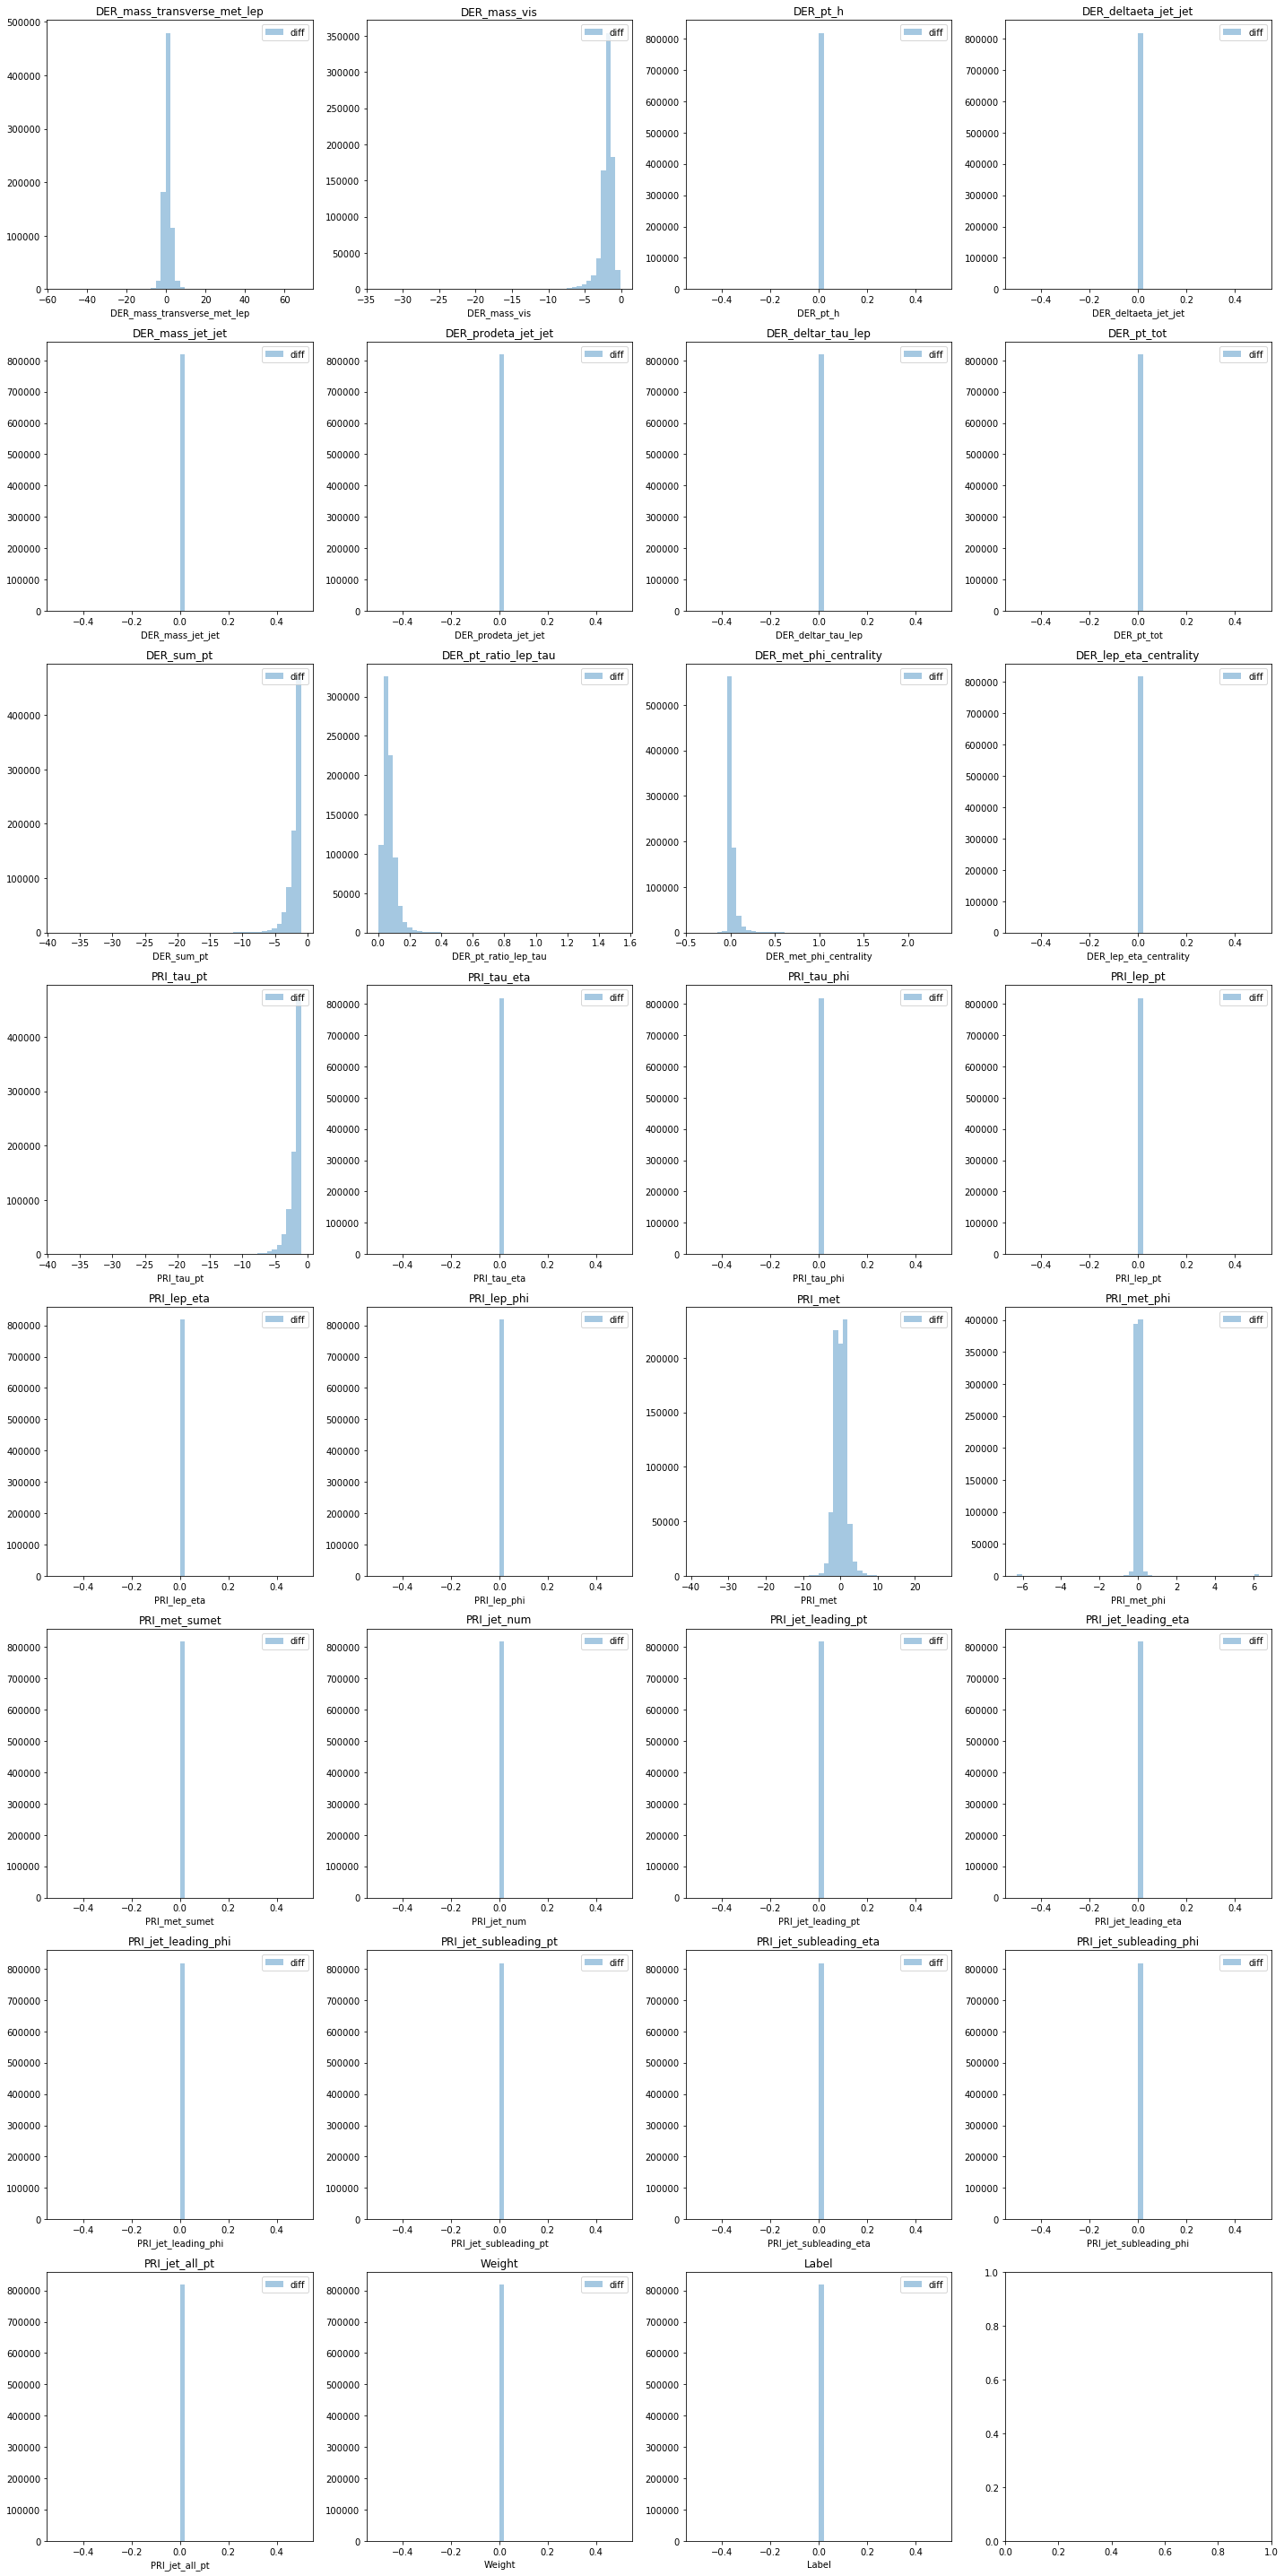

In [9]:
cols = changed_cols

n_features = len(cols)
n_plot_cols = 4
n_plot_raws = n_features//n_plot_cols + (1 if (n_features % n_plot_cols) > 0 else 0 )
fig, axes = plt.subplots(n_plot_raws, n_plot_cols, figsize=(5*n_plot_cols,5*n_plot_raws))
axes = axes.ravel()

for i in range(n_features):
    sns.distplot(diff[cols[i]], ax=axes[i], label='diff', kde=False)
    axes[i].set_title(cols[i])  # Title = feature name
    axes[i].legend(loc=1)

plt.tight_layout()  # Avoid plot collision
plt.show()

### Sanity check

In [ ]:
cols = unchanged_cols

n_features = len(cols)
n_plot_cols = 4
n_plot_raws = n_features//n_plot_cols + (1 if (n_features % n_plot_cols) > 0 else 0 )
fig, axes = plt.subplots(n_plot_raws, n_plot_cols, figsize=(5*n_plot_cols,5*n_plot_raws))
axes = axes.ravel()

for i in range(n_features):
    sns.distplot(diff[cols[i]], ax=axes[i], label='diff', kde=False)
    axes[i].set_title(cols[i])  # Title = feature name
    axes[i].legend(loc=1)

plt.tight_layout()  # Avoid plot collision
plt.show()

## Relative difference

In [10]:
diff = skew(data, sysTauEnergyScale=1.0) - skew(data, sysTauEnergyScale=z)
diff = diff / (skew(data, sysTauEnergyScale=1.0) + 1e-8)
diff.fillna(0.0, inplace=True)

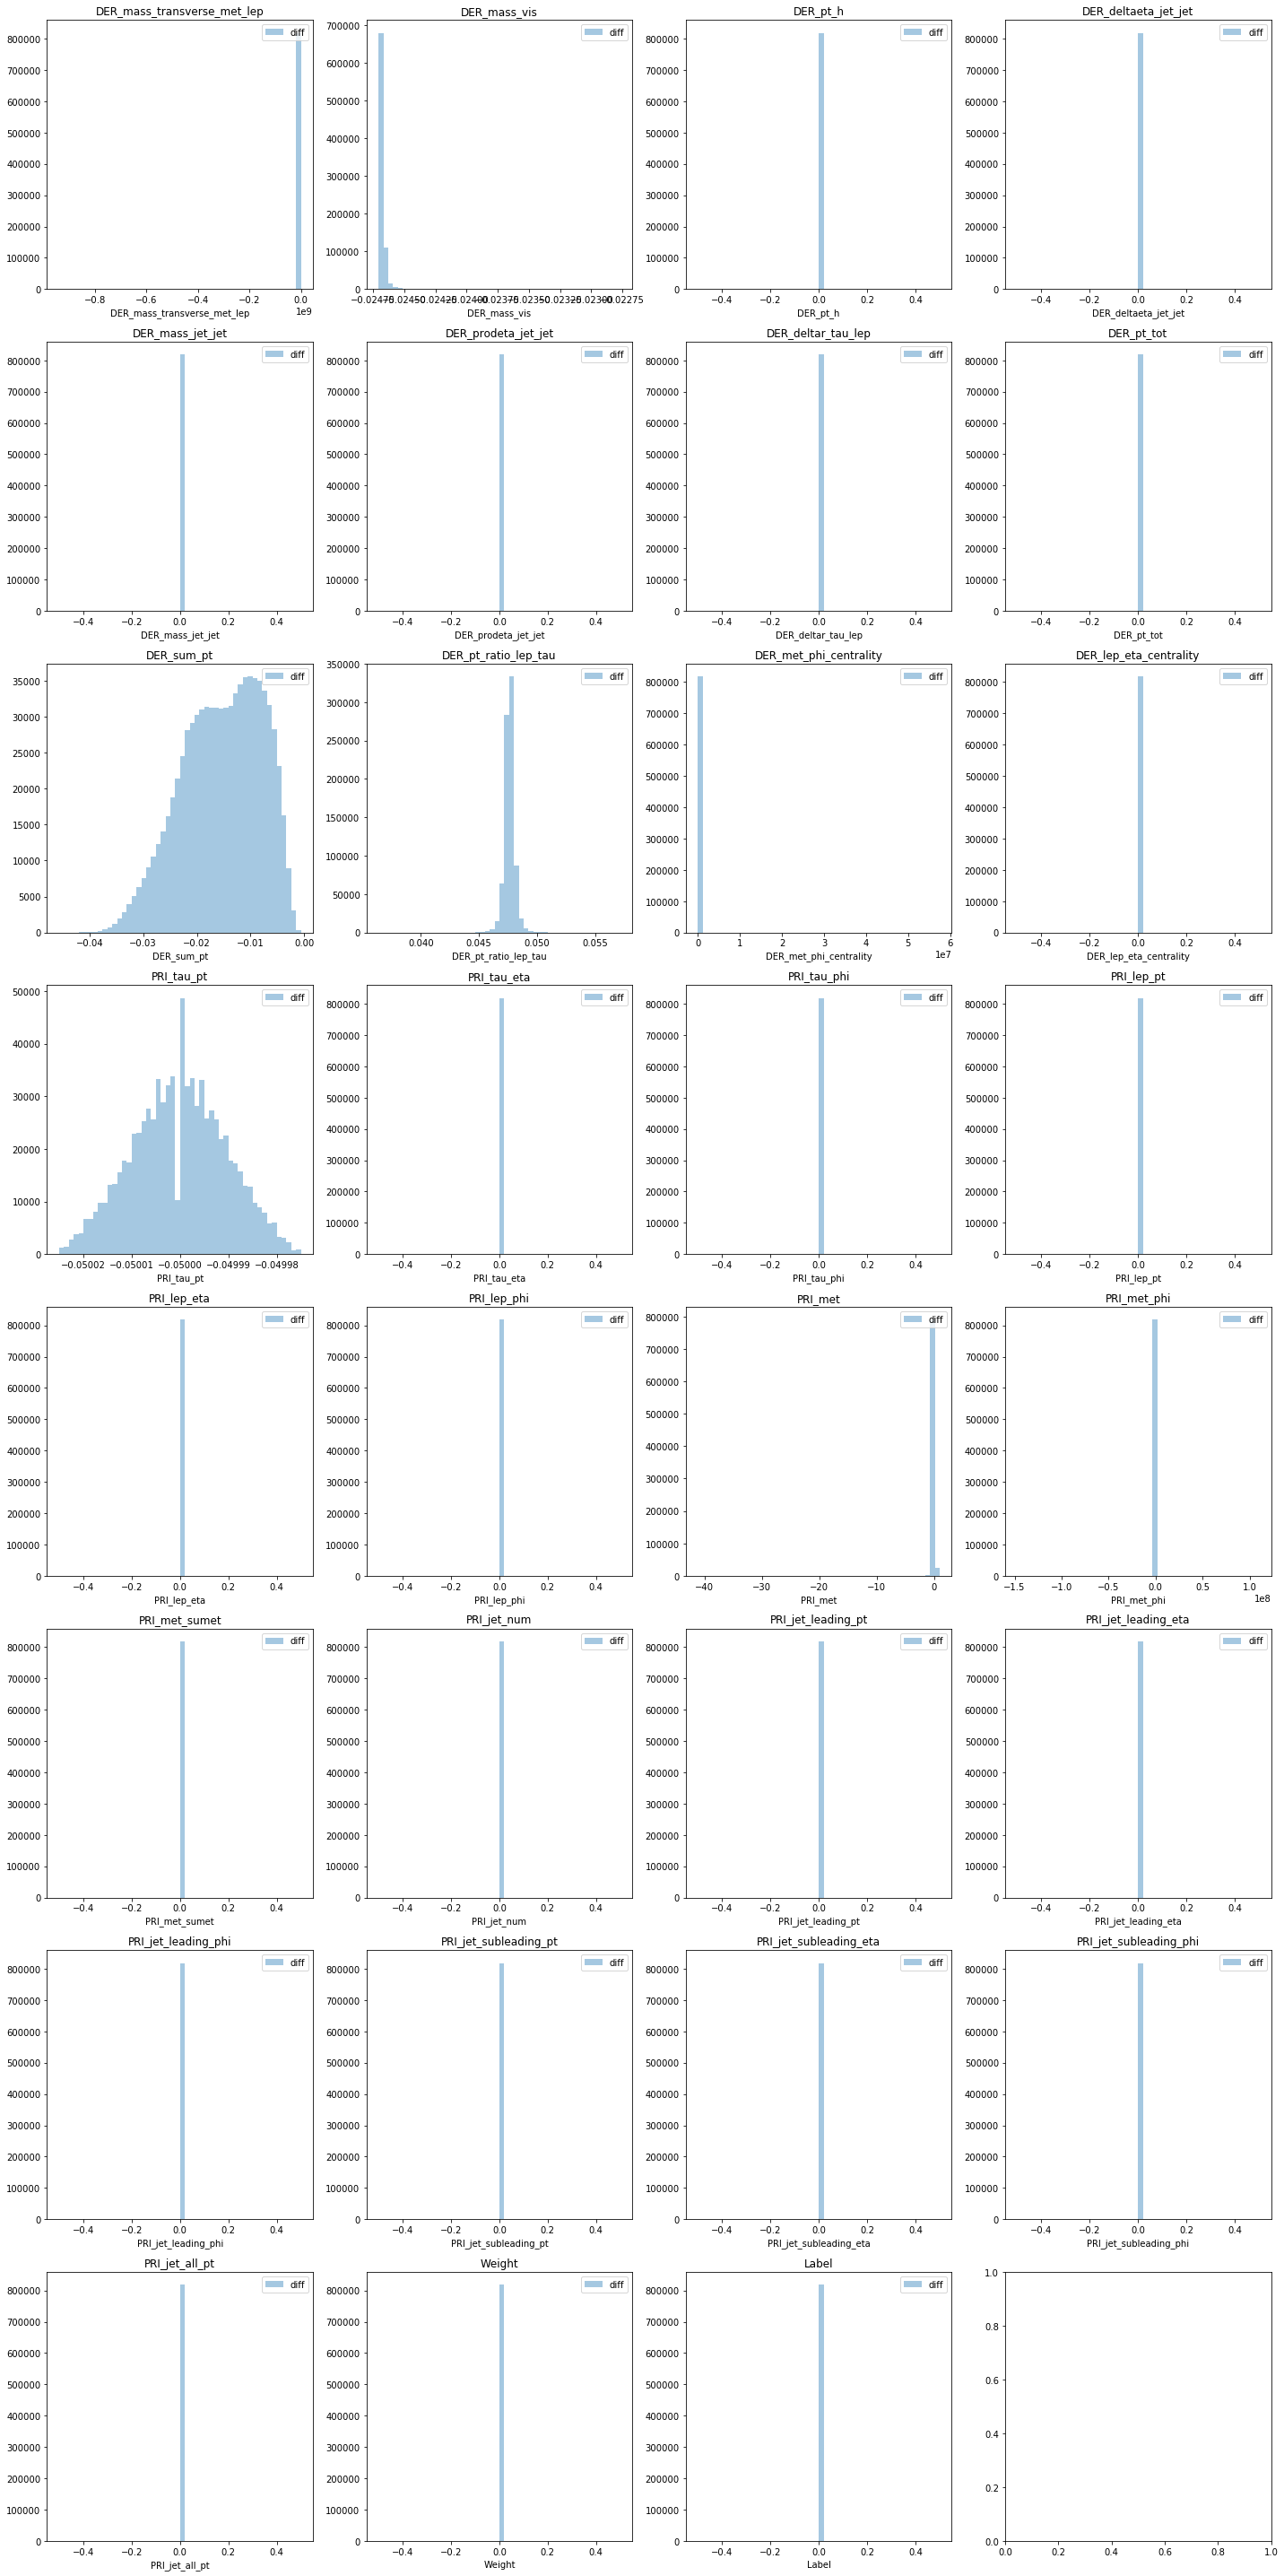

In [11]:
cols = diff.columns  # get column names to do indexing on pandas.DataFrames

n_features = len(cols)
n_plot_cols = 4
n_plot_raws = n_features//n_plot_cols + (1 if (n_features % n_plot_cols) > 0 else 0 )
fig, axes = plt.subplots(n_plot_raws, n_plot_cols, figsize=(5*n_plot_cols,5*n_plot_raws))
axes = axes.ravel()

for i in range(n_features):
    sns.distplot(diff[cols[i]], ax=axes[i], label='diff', kde=False)
    axes[i].set_title(cols[i])  # Title = feature name
    axes[i].legend(loc=1)

plt.tight_layout()  # Avoid plot collision
plt.show()

# Classification 

Here I measure the capacity of some classifier to separate between nominal data and skewed data.

If there is a data leakage, maybe some classfier will have very good performances on this task.

In [36]:
z = 1.05

## Build problem

I need 4 parts
0. the train unskewed
0. the train skewed
0. the test unskewed
0. the test skewed

In [37]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import check_cv
from sklearn.model_selection import train_test_split


In [38]:
def make_classification(data, z):
    data_0, data_1 = train_test_split(data, test_size=0.5)
    data_0 = cut( skew(data_0, sysTauEnergyScale=1.0) )
    data_1 = cut( skew(data_1, sysTauEnergyScale=z) )
    X = pd.concat([data_0.drop(["Weight", "Label"], axis=1), data_1.drop(["Weight", "Label"], axis=1)] )
    y = np.concatenate( (np.zeros(data_0.shape[0]), np.ones(data_1.shape[0])) )
    return X, y


In [39]:
def cv_score(model, X, y, cv=ShuffleSplit(n_splits=3, test_size=0.2)):
    cv = check_cv(cv)
    train_scores = []
    test_scores = []
    for train_idx, test_idx in cv.split(X, y):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_test = X[test_idx]
        y_test = y[test_idx]
        
        model.fit(X_train, y_train)
        
        sc = model.score(X_train, y_train)
        train_scores.append(sc)
        
        sc = model.score(X_test, y_test)
        test_scores.append(sc)
    
    return train_scores, test_scores


In [40]:
def test_all_z(model, data, z_list=(0.95, 1.0, 1.05)):
    many_z = []
    train_scores = []
    test_scores = []
    
    for z in z_list:
        print(now(), 'testing z = {} ...'.format(z), flush=True)
        X, y = make_classification(data, z)
        cv = ShuffleSplit(n_splits=3, test_size=0.2)
        n_cv = cv.n_splits
        train_sc, test_sc = cv_score(model, X.values, y)
        
        many_z.extend([z]*n_cv)
        train_scores.extend(train_sc)
        test_scores.extend(test_sc)
    return many_z, train_scores, test_scores
        

## Logistic regression

In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
log_reg = LogisticRegression()
z_list = [0.90, 0.92, 0.95, 0.98, 1.0, 1.02, 1.05, 1.08, 1.10]

In [52]:
many_z, train_scores, test_scores = test_all_z(log_reg, data, z_list=z_list)

2017-09-27 16:22:51 testing z = 0.9 ...
2017-09-27 16:24:20 testing z = 0.92 ...
2017-09-27 16:25:49 testing z = 0.95 ...
2017-09-27 16:27:19 testing z = 0.98 ...
2017-09-27 16:28:45 testing z = 1.0 ...
2017-09-27 16:30:24 testing z = 1.02 ...
2017-09-27 16:32:04 testing z = 1.05 ...
2017-09-27 16:33:41 testing z = 1.08 ...
2017-09-27 16:35:24 testing z = 1.1 ...


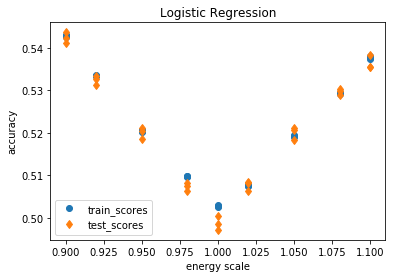

In [53]:
plt.plot(many_z, train_scores, 'o', label='train_scores')
plt.plot(many_z, test_scores, 'd', label='test_scores')
plt.title('Logistic Regression')
plt.xlabel('energy scale')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Random Forest

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
rand_forest = RandomForestClassifier()
z_list = [0.90, 0.92, 0.95, 0.98, 1.0, 1.02, 1.05, 1.08, 1.10]

In [56]:
many_z, train_scores, test_scores = test_all_z(rand_forest, data, z_list=z_list)

2017-09-27 16:37:05 testing z = 0.9 ...
2017-09-27 16:39:04 testing z = 0.92 ...
2017-09-27 16:41:12 testing z = 0.95 ...
2017-09-27 16:43:36 testing z = 0.98 ...
2017-09-27 16:46:38 testing z = 1.0 ...
2017-09-27 16:50:25 testing z = 1.02 ...
2017-09-27 16:53:32 testing z = 1.05 ...
2017-09-27 16:56:07 testing z = 1.08 ...
2017-09-27 16:58:35 testing z = 1.1 ...


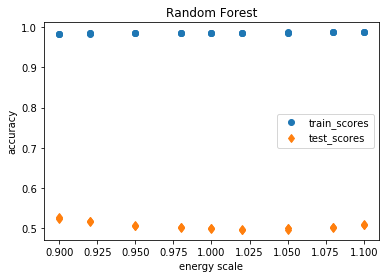

In [57]:
plt.plot(many_z, train_scores, 'o', label='train_scores')
plt.plot(many_z, test_scores, 'd', label='test_scores')
plt.title('Random Forest')
plt.xlabel('energy scale')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Gradient Boosting

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

In [59]:
grad_boost = GradientBoostingClassifier()
z_list = [0.90, 0.92, 0.95, 0.98, 1.0, 1.02, 1.05, 1.08, 1.10]

In [60]:
many_z, train_scores, test_scores = test_all_z(grad_boost, data, z_list=z_list)

2017-09-27 17:00:58 testing z = 0.9 ...
2017-09-27 17:08:42 testing z = 0.92 ...
2017-09-27 17:16:31 testing z = 0.95 ...
2017-09-27 17:24:35 testing z = 0.98 ...
2017-09-27 17:32:40 testing z = 1.0 ...
2017-09-27 17:41:25 testing z = 1.02 ...
2017-09-27 17:50:36 testing z = 1.05 ...
2017-09-27 18:00:18 testing z = 1.08 ...
2017-09-27 18:10:18 testing z = 1.1 ...


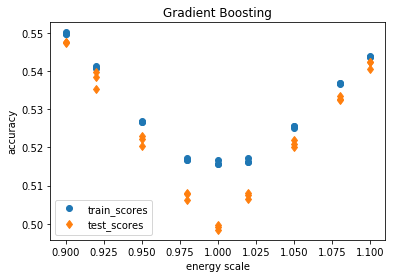

In [61]:
plt.plot(many_z, train_scores, 'o', label='train_scores')
plt.plot(many_z, test_scores, 'd', label='test_scores')
plt.title('Gradient Boosting')
plt.xlabel('energy scale')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Neural net

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

from minibatch import OneEpoch, EpochShuffle
from itertools import islice


In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(29, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    def reset_parameters(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()
        self.fc3.reset_parameters()
        self.bn1.reset_parameters()
        self.bn2.reset_parameters()


In [65]:
from sklearn.base import BaseEstimator
from minibatch import OneEpoch, EpochShuffle
from itertools import islice

class NNClassifier(BaseEstimator):
    def __init__(self, learning_rate=1e-3, verbose=0):
        super().__init__()
        self.net = Net()
        self.learning_rate = learning_rate
        self.verbose = verbose
    
    def fit(self, X, y, batch_size=1024, n_steps=3000):
        self.net.reset_parameters()
        self.losses = []

        X = X.astype(np.float32)
        y = y.astype(np.int64)
        
        lr = self.learning_rate
        self.net = self.net.cuda()
        net = self.net
        net.train()
        optimizer = optim.Adam(net.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss().cuda()
        
        batch_gen = EpochShuffle(X, y, batch_size=batch_size)
        for i, (X_batch, y_batch) in enumerate(islice(batch_gen, n_steps)):
            net.train() # train mode
            X_batch = Variable(torch.from_numpy(X_batch)).cuda()
            y_batch = Variable(torch.from_numpy(y_batch)).cuda()
            optimizer.zero_grad() # zero-out the gradients because they accumulate by default
            y_pred = net(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward() # compute gradients
            optimizer.step() # update params
            if self.verbose and (i % 100) == 0 :
                print( 'Epoch {}, [{} / {} samples] : loss = {}'.format(batch_gen.epoch, batch_gen.yielded, batch_gen.size, loss.data[0]) )
                self.losses.append(loss.data[0])
        return self

    def predict_proba(self, X, batch_size=1024):
        batch_gen = OneEpoch(X, batch_size=batch_size)
        y_proba = []
        self.net.eval()
        for X_batch in batch_gen:
            X_batch = X_batch.astype(np.float32)
            X_batch = Variable(torch.from_numpy(X_batch)).cuda()
            proba_batch = nn.Softmax()(self.net(X_batch)).cpu().data.numpy()
            y_proba.extend(proba_batch)
        y_proba = np.array(y_proba)
        return y_proba 

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def score(self, X, y):
        pred = np.argmax(self.predict_proba(X), axis=1)
        return np.mean( pred == y )


In [66]:
nn_clf = NNClassifier(learning_rate=1e-2)
z_list = [0.90, 0.92, 0.95, 0.98, 1.0, 1.02, 1.05, 1.08, 1.10]

In [67]:
many_z, train_scores, test_scores = test_all_z(nn_clf, data, z_list=z_list)

2017-09-27 18:20:48 testing z = 0.9 ...
2017-09-27 18:21:26 testing z = 0.92 ...
2017-09-27 18:22:00 testing z = 0.95 ...
2017-09-27 18:22:39 testing z = 0.98 ...
2017-09-27 18:23:16 testing z = 1.0 ...
2017-09-27 18:23:54 testing z = 1.02 ...
2017-09-27 18:24:32 testing z = 1.05 ...
2017-09-27 18:25:09 testing z = 1.08 ...
2017-09-27 18:25:46 testing z = 1.1 ...


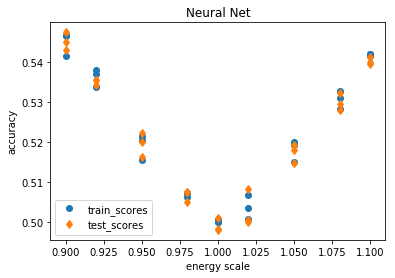

In [68]:
plt.plot(many_z, train_scores, 'o', label='train_scores')
plt.plot(many_z, test_scores, 'd', label='test_scores')
plt.title('Neural Net')
plt.xlabel('energy scale')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Regression